# SDFusion: Text-guided Generation (txt2shape)

### TODO: add sample results or teaser images

In [1]:
# first set up which gpu to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"

In [2]:
# import libraries
import numpy as np
from IPython.display import Image as ipy_image
from IPython.display import display
from termcolor import colored, cprint

import torch
print(torch.cuda.is_available())
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils

from models.base_model import create_model
from utils.util_3d import render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif

%load_ext autoreload
%autoreload 2

/root/miniconda3/envs/sdfusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [3]:
# options for the model. please check `utils/demo_util.py` for more details
from utils.demo_util import SDFusionText2ShapeOpt

seed = 2023
opt = SDFusionText2ShapeOpt(gpu_ids=gpu_ids, seed=seed)
device = opt.device

[*] SDFusionText2ShapeOption initialized.


In [4]:
# enable proxy for huggingface

import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [15]:
# initialize SDFusion model
# ckpt_path = 'saved_ckpt/sdfusion-txt2shape.pth'
# ckpt_path = '/root/autodl-tmp/SDFusion/logs_home/continue-2024-04-05T17-15-19-sdfusion-txt2shape-text2shape-all-LR1e-5-clean-code/ckpt/df_steps-latest.pth'
# ckpt_path = '/root/autodl-tmp/SDFusion/logs_home/2024-03-27T14-52-09-sdfusion-txt2shape-text2shape-all-LR1e-5-clean-code/ckpt/df_steps-latest.pth'
# vqvae_path = '/root/autodl-tmp/SDFusion/logs_home/continue-2024-03-27T11-26-32-vqvae-snet-all-res64-LR1e-4-T0.2-release/ckpt/vqvae_epoch-best.pth'

ckpt_path = '/root/autodl-tmp/SDFusion/logs_home/2024-04-20T01-01-11-sdfusion-txt2shape-text2shape-all-LR1e-5-clean-code/ckpt/df_steps-latest.pth'
# ckpt_path = '/root/autodl-tmp/SDFusion/logs_home/continue-2024-04-19T21-55-32-sdfusion-txt2shape-text2shape-all-LR1e-5-clean-code/ckpt/df_steps-latest.pth'
vqvae_path = '/root/autodl-tmp/SDFusion/logs_home/continue-2024-04-19T14-51-01-vqvae-snet-all-res64-LR1e-5-T0.2-release/ckpt/vqvae_epoch-best.pth'
opt.init_model_args(ckpt_path=ckpt_path, vq_ckpt_path=vqvae_path)

SDFusion = create_model(opt)
cprint(f'[*] "{SDFusion.name()}" loaded.', 'cyan')

Working with z of shape (1, 3, 16, 16, 16) = 12288 dimensions.
[*] VQVAE: weight successfully load from: /root/autodl-tmp/SDFusion/logs_home/continue-2024-04-19T14-51-01-vqvae-snet-all-res64-LR1e-5-T0.2-release/ckpt/vqvae_epoch-best.pth
[*] weight successfully load from: /root/autodl-tmp/SDFusion/logs_home/2024-04-20T01-01-11-sdfusion-txt2shape-text2shape-all-LR1e-5-clean-code/ckpt/df_steps-latest.pth
[*] setting ddim_steps=100
[*] Model has been created: SDFusion-Text2Shape-Model
[*] "SDFusion-Text2Shape-Model" loaded.


## SDFusion: text-guided generation (txt2shape)

In [13]:
test_actuator_descriptions = [
    'spiral off axis variable segmented bending inner fold based 1dof soft actuator',
    'long fold based 1 dof pure bending soft actuator',
    'short circular fold based 1 dof pure bending soft actuator',
    'dome shaped cylindrical fold based normal bidirectional 2dof bending soft actuator',
    'long bellow type 1 dof pure bending soft actuator',
    'dome shaped cylindrical fold based normal bidirectional 2dof variable bending short soft actuator',
    'multi-layer spiral segmented variable 1dof soft actuator with internal folds',
    'extended linear fold-based 1dof pure bending soft actuator',
    'compact spiral fold-based 1dof variable bending soft actuator',
    'curved bellow type 2 dof bidirectional bending soft actuator',
    'elongated accordion fold-based 1dof bending soft actuator',
    'twisted ribbon style 1dof variable length soft actuator',
    'accordion pleat-based 1 dof linear bending soft actuator',
    'spherical articulated fold-based 3dof omnidirectional soft actuator',
    'zigzag crease fold-based 1dof precise bending soft actuator',
    'circular segmented pleat-based 2 dof radial bending soft actuator',
    'helical coiled 1dof continuous bending soft actuator',
    'layered fan fold-based 1dof controlled bending soft actuator',
    'expanding circle fold-based 2dof dynamic bending soft actuator',
    'conical spiral fold-based 1 dof gradual bending soft actuator',
    'triangular pleated 1dof angular bending soft actuator',
    'double helix segment-based 2dof rotational bending soft actuator',
    'variable pitch bellow type 1dof adaptive bending soft actuator',
    'slotted linear fold-based 1 dof stiff bending soft actuator',
    'perforated cylindrical fold-based 1dof focused bending soft actuator',
    'interlocking square fold-based 2dof complex bending soft actuator',
    'wide range spiral segmented 1dof flexing soft actuator',
    'short linear segmented 1dof precision bending soft actuator',
    'longitudinal accordion-style 1dof elastic bending soft actuator',
    'cross-linked dome shaped 2dof expansive bending soft actuator',
    'dual-layer dome shaped fold-based 2dof variable soft actuator',
    'segmented ribbon fold-based 1dof controlled bending soft actuator',
    'narrow spiral off-axis segmented 1dof soft actuator',
    'parallel pleat-based 1dof uniform bending soft actuator',
    'bi-directional bellow type 2 dof folding soft actuator',
    'articulated zigzag fold-based 1dof directional bending soft actuator',
    'concentric ring fold-based 2dof adaptive bending soft actuator',
    'longitudinal rib fold-based 1dof linear soft actuator',
    'angular segmented variable length 1dof bending soft actuator',
    'variable geometry dome shaped 2dof soft actuator',
    'multi-segmented accordion fold 1dof dynamic bending soft actuator',
    'tight coil spiral 1dof compact bending soft actuator',
    'uniform bellow type 1dof extensive bending soft actuator',
    'articulated strip fold-based 1dof precise bending soft actuator',
    'short cylindrical segmented 1dof pure bending soft actuator',
    'multi-layer longitudinal fold-based 1dof bending soft actuator',
    'segmented dome shaped variable 2dof bending soft actuator',
    'adjustable pitch spiral 1dof soft actuator',
    'accordion-style longitudinal 1dof flexible soft actuator',
    'highly articulated cylindrical fold-based 2dof soft actuator',
    'radial pleat fold-based 1dof adaptive bending soft actuator',
    'compact dome shaped 2dof bidirectional bending soft actuator',
    'expandable zigzag segmented 1dof bending soft actuator',
    'variable geometry bellow type 1dof bending soft actuator',
    'layered linear segmented 1dof soft actuator',
    'longitudinal rib-style 1dof dynamic bending soft actuator',
    'miniature spiral fold-based 1dof variable bending soft actuator',
    'extended accordion fold-based 1dof uniform bending soft actuator',
    'articulated ribbon style 1dof adjustable bending soft actuator',
    'zigzag pleated fold-based 1dof controlled bending soft actuator',
    'compact dome shaped cylindrical fold 2dof soft actuator',
    'wide-range spiral off-axis 1dof bending soft actuator',
    'double helix style 2 dof rotational soft actuator',
    'parallel segmented variable 1dof soft actuator',
    'high precision cylindrical segmented 1dof bending soft actuator',
    'triangular pleated variable 1dof bending soft actuator',
    'multi-layer dome shaped fold-based 2dof complex bending soft actuator',
    'adjustable longitudinal segmented 1dof soft actuator',
    'variable length spiral fold-based 1dof soft actuator',
    'helical pitch segmented 1dof adaptive bending soft actuator',
    'dual-layer cylindrical fold-based 2dof precise bending soft actuator',
    'articulated strip style 1dof dynamic bending soft actuator',
    'perforated accordion fold-based 1dof soft actuator',
    'compact spiral off-axis variable segmented 1dof soft actuator',
    'elongated bellow type 1 dof pure bending soft actuator',
    'high capacity spiral fold-based 1dof variable bending soft actuator',
    'variable pitch bellow type 1dof soft actuator',
    'segmented linear fold-based 1dof precise bending soft actuator',
    'expandable cylindrical fold-based 1dof focused bending soft actuator',
    'articulated square fold-based 2dof complex bending soft actuator',
    'wide range spiral segmented 1dof bending soft actuator',
    'short linear segmented 1dof precision bending soft actuator',
    'longitudinal accordion-style 1dof elastic bending soft actuator',
    'cross-linked dome shaped 2dof expansive bending soft actuator',
    'dual-layer dome shaped fold-based 2dof variable bending soft actuator',
    'segmented ribbon fold-based 1dof controlled bending soft actuator',
    'narrow spiral off-axis segmented 1dof variable soft actuator',
    'parallel pleat-based 1dof uniform bending soft actuator',
    'bi-directional bellow type 2 dof folding soft actuator',
    'articulated zigzag fold-based 1dof directional bending soft actuator',
    'concentric ring fold-based 2dof adaptive bending soft actuator',
    'longitudinal rib fold-based 1dof linear soft actuator',
    'angular segmented variable length 1dof bending soft actuator',
    'variable geometry dome shaped 2dof adaptive soft actuator',
    'multi-segmented accordion fold 1dof dynamic bending soft actuator',
    'tight coil spiral 1dof compact bending soft actuator',
    'uniform bellow type 1dof extensive bending soft actuator',
    'articulated strip fold-based 1dof precise bending soft actuator',
    'short cylindrical segmented 1dof pure bending soft actuator',
    'multi-layer longitudinal fold-based 1dof bending soft actuator',
    'segmented dome shaped variable 2dof bending soft actuator'
]
print(f'Number of test actuator descriptions: {len(test_actuator_descriptions)}')

Number of test actuator descriptions: 101


In [10]:
test_actuator_descriptions = [
'fold based 1 dof pure bending soft actuator',
'bending with minor small slight extension soft actuator',
'curved rounded bellow 1 dof pure bending soft actuator',
'dome shaped cylindrical fold based increased bidirectional 2 dof bending soft actuator',
'dome shaped cylindrical fold based normal bidirectional 2dof 2 section variable bending short soft actuator',
'dome shaped cylindrical fold based normal bidirectional 2dof bending short soft actuator',
'dome shaped cylindrical fold based normal bidirectional 2dof bending soft actuator',
'dome shaped cylindrical fold based normal bidirectional 2dof variable bending short soft actuator',
'flat fold based 1 dof pure bending soft actuator',
'fold based 1 dof pure bending soft actuator',
'fold based biased one sided bending half strain limiting base soft actuator',
'fold based extension 1dof soft actuator',
'fold based multi segmented modular bending with extension variable strain limiting base soft actuator',
'fold based reduced variable bending triangle base soft actuator',
'fold based twisting toroidal soft actuator',
'long bellow type 1 dof pure bending soft actuator',
'long bending with extension soft actuator',
'long fold based 1 dof pure bending soft actuator',
'low profile bellow type 1 dof bending soft actuator',
'mixed dimension fold based variable pure bending soft actuator',
'pure bending inner fold based 1dof soft actuator',
'pure planar bidirectional bending fold based 2dof soft actuator',
'pure planar inproportionate biased bidirectional bending fold based 2dof soft actuator',
'short circular fold based 1 dof pure bending soft actuator',
'short fold based 1 dof pure bending soft actuator',
'short fold based pure bending 1dof soft actuator',
'spiral off axis bending inner fold based 1dof soft actuator',
'spiral off axis variable segmented bending inner fold based 1dof soft actuator',
'3 dome shaped cylindrical fold based normal bidirectional 2dof variable bending short soft actuator',
'4 dome shaped cylindrical fold based normal bidirectional 2dof variable bending short soft actuator',
'5 dome shaped cylindrical fold based normal bidirectional 2dof variable bending short soft actuator',
'6 dome shaped cylindrical fold based normal bidirectional 2dof variable bending short soft actuator',
'7 dome shaped cylindrical fold based normal bidirectional 2dof variable bending short soft actuator',
'dome shaped cylindrical fold based normal bidirectional 2dof bending soft actuator 4 folds short',
'dome shaped cylindrical fold based normal bidirectional 2dof bending soft actuator 5 folds short',
'dome shaped cylindrical fold based normal bidirectional 2dof bending soft actuator 6 folds short',
'dome shaped cylindrical fold based normal bidirectional 2dof bending soft actuator 7 folds short',
'dome shaped cylindrical fold based normal bidirectional 2dof bending soft actuator 8 folds long',
'dome shaped cylindrical fold based normal bidirectional 2dof bending soft actuator 9 folds long',
'dome shaped cylindrical fold based normal bidirectional 2dof bending soft actuator 10 folds long',
'dome shaped cylindrical fold based normal bidirectional 2dof bending soft actuator 11 folds long',
'fold based extension 1dof soft actuator 3 folds short',
'fold based extension 1dof soft actuator 4 folds short',
'fold based extension 1dof soft actuator 5 folds short',
'fold based extension 1dof soft actuator 6 folds short',
'fold based extension 1dof soft actuator 7 folds short',
'fold based extension 1dof soft actuator 8 folds long',
'fold based extension 1dof soft actuator 9 folds long',
'fold based extension 1dof soft actuator 10 folds long',
'fold based extension 1dof soft actuator 11 folds long',
'fold based extension 1dof soft actuator 12 folds long',
'fold based extension 1dof soft actuator 13 folds long',
'long bellow type 1 dof pure bending 8 folds soft actuator',
'short bellow type 1 dof pure bending 3 folds soft actuator',
'short bellow type 1 dof pure bending 4 folds soft actuator',
'short bellow type 1 dof pure bending 5 folds soft actuator',
'short bellow type 1 dof pure bending 6 folds soft actuator',
'short bellow type 1 dof pure bending 7 folds soft actuator',
'pure planar 5 folds short inproportionate biased bidirectional bending fold based 2dof soft actuator',
'pure planar 6 folds short inproportionate biased bidirectional bending fold based 2dof soft actuator',
'pure planar 8 folds long inproportionate biased bidirectional bending fold based 2dof soft actuator',
'pure planar 10 folds long inproportionate biased bidirectional bending fold based 2dof soft actuator',
'pure planar 12 folds long inproportionate biased bidirectional bending fold based 2dof soft actuator',
'pure planar 15 folds long inproportionate biased bidirectional bending fold based 2dof soft actuator',
'pure planar inproportionate biased bidirectional bending fold based 2dof soft actuator 3 folds short',
'pure planar inproportionate biased bidirectional bending fold based 2dof soft actuator 4 folds short',
'pure planar inproportionate biased bidirectional bending fold based 2dof soft actuator 5 folds short',
'pure planar inproportionate biased bidirectional bending fold based 2dof soft actuator 6 folds short',
'pure planar inproportionate biased bidirectional bending fold based 2dof soft actuator 7 folds short',
'pure planar inproportionate biased bidirectional bending fold based 2dof soft actuator 8 folds long',
]
print(f'Number of test actuator descriptions: {len(test_actuator_descriptions)}')

Number of test actuator descriptions: 100


[101/101] Generating shape for "segmented dome shaped variable 2dof bending soft actuator"
Data shape for DDIM sampling is (1, 3, 16, 16, 16), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler:   0%|          | 0/100 [00:00<?, ?it/s]

DDIM Sampler: 100%|██████████| 100/100 [00:10<00:00,  9.21it/s]


Input: "segmented dome shaped variable 2dof bending soft actuator"


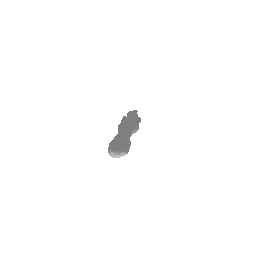

In [16]:
# txt2shape
from pytorch3d.io import save_obj
from IPython.display import clear_output
from utils.util_3d import rotate_mesh

base_out_dir = 'test_results_nopre_large_dset'
if not os.path.exists(base_out_dir): os.makedirs(base_out_dir)
gif_out_dir = f'{base_out_dir}/gif'
if not os.path.exists(gif_out_dir): os.makedirs(gif_out_dir)
obj_out_dir = f'{base_out_dir}/obj'
if not os.path.exists(obj_out_dir): os.makedirs(obj_out_dir)

for i, input_txt in enumerate(test_actuator_descriptions):
    # clear notebook output, to avoid cluttering
    clear_output()
    print(f'[{i+1}/{len(test_actuator_descriptions)}] Generating shape for "{input_txt}"')

    ngen = 1  # number of generated shapes
    ddim_steps = 100
    ddim_eta = 0.
    uc_scale = 3.

    sdf_gen = SDFusion.txt2shape(input_txt=input_txt, ngen=ngen, ddim_steps=ddim_steps, ddim_eta=ddim_eta, uc_scale=uc_scale)

    mesh_gen = sdf_to_mesh(sdf_gen)

    # vis as gif
    gen_name = f'{gif_out_dir}/{i}-txt2shape-{input_txt}.gif'
    save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

    print(f'Input: "{input_txt}"')
    for name in [gen_name]:
        display(ipy_image(name))

    # save mesh as obj
    obj_name = f'{obj_out_dir}/txt2shape-{input_txt}-{i}.obj'
    save_obj(obj_name, mesh_gen.verts_list()[0], mesh_gen.faces_list()[0])

    mesh_gen = rotate_mesh(mesh_gen, axis='x', angle=180)
    gen_name = f'{gif_out_dir}/{i}-txt2shape-{input_txt}-upside-down.gif'
    save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)